# Exploring Linear Regression

Welcome everybody! I'm going to be exploring some different types of Linear Regression in this article and how to build models with them. Today's dataset is NHL player stats from 20082009 to present and we'll attempt to predict a players goal totals previous season stats. Just a heads up that the purpose of this article is to explore Linear Regression models and how to build/evaluate them, not to build the best possible model! Yes there are probably better options to solve this problem. However Linear Regression is great for building base line models; a model you can measure future results against. Sometimes you may find that the model you spent days training barely outperforms a Linear Regression that took 5 minutes! Without the baseline model to compare against, it would be impossible to tell how well the model actually works outside the vacuum of your experiement. I will be providing the code I'll be using 

## Thanks

I'd like to think Josh and Luke Youngreen, Ben Baldwin, and Andrew Patton for reading and providing feed back on this article

Importing packages we'll need for the model building. Ill be using Scikit-Learn for the model building, pandas/numpy for data shaping, and seaborn/matplotlib.

In [232]:
import os
import math
from functools import reduce
import itertools
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Here I'm pulling in box score stats at even strength and power play regular season stats for all players from 20072008 to present. All data provided by evolving-hockey.com

In [233]:
#reading in csv files to dataframes
ev_df = pd.read_csv('ev_player_goal_data.csv')
pp_df = pd.read_csv('pp_player_goal_data.csv')


Here I'm grouping the rows together of the dataframes because some players played for multiple teams so I'm roling them up so there will be one row for each player/season combo

In [234]:
def group_data(df):
    df.season = df.season.astype(int)
    df['prev_season'] = df['season'] - 10001
    groupby_columns = ['player', 'api_id', 'season', 'player_upper', 
                       'birthday', 'position', 'shoots',
                       'prev_season', 'position_type', 
                       'season_age']
    agg_columns = ['g', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf']
    df = df.groupby(groupby_columns)[agg_columns].sum().reset_index()
    return df

ev_df = group_data(ev_df)
pp_df = group_data(pp_df)

### Dataframe Shaping

In [235]:
#join the pp stats to the regular stats
total_df = ev_df.merge(pp_df[['api_id', 'g', 'a1', 'a2', 'season',
                              'points', 'toi', 'gp', 'isf', 'iff', 'icf']], 
                       on=['api_id', 'season'],
                       how='left',
                       suffixes=[None, '_pp'])

total_df.fillna(0, inplace=True)


#create dataframe of season to season goal correlation
next_df = total_df.merge(total_df[['api_id', 'season', 'prev_season', 'g', 'g_pp', 'season_age']], 
                         how='left',
                         left_on=['api_id', 'season'], 
                         right_on=['api_id', 'prev_season'],
                         suffixes=[None, '_next'])

next_df['total_goals_next'] = next_df['g_next'] + next_df['g_pp_next']
next_df['total_goals'] = next_df['g'] + next_df['g_pp']

### Feature Selection/Creation


In [236]:
#features:
#2. player age
#4. position (dummy variable)
#5. toi_gp
#6. previous years goals 
#7. previous years a1 
#8. previous years a2 
#9. previous years points 
#10. Past average of past two years 
#11. pp_toi
#12. shooting percentage
#13. shooting percentage difference from carreer shooting percentage 
#14. career goals per season average 
#position dummy variable
next_df = pd.concat([next_df, pd.get_dummies(next_df['position_type'], prefix='pos')], axis=1)
#toi_gp
next_df['toi_gp'] = round(next_df['toi']/next_df['gp'], 2)
next_df['sh_percent'] = round(next_df['g']/next_df['isf'], 3)
next_df['sh_percent_pp'] = round(next_df['g_pp']/next_df['isf_pp'], 3)

#avg goals over career
next_df = next_df.sort_values(['api_id', 'season'])
next_df["number_season"] = next_df.groupby("api_id")["season"].rank(method="first", ascending=True)

next_df['goals_shift'] = next_df['g'] + next_df['g'].shift(1)
next_df['cum_goals'] = np.where(next_df['api_id'] == next_df['api_id'].shift(1), 
                                    next_df['goals_shift'], 
                                    next_df['g'])
next_df['avg_goals_season'] = next_df['cum_goals']/next_df['number_season']

#avg shooting percentage over career
next_df['cum_shots'] = np.where(next_df['api_id'] == next_df['api_id'].shift(1), 
                                    next_df['isf'] + next_df['isf'].shift(1), 
                                    next_df['isf'])
next_df['avg_sh_perc'] = round(next_df['cum_goals']/next_df['cum_shots'], 3)

#diff of season sh% from career avg
next_df['sh_perc_diff'] = next_df['sh_percent'] - next_df['avg_sh_perc']

#last two seasons avg
next_df['next_prev_season'] = next_df['prev_season'] - 10001
next_df = next_df.merge(next_df[['api_id', 'season', 'g']], 
                        left_on=['api_id', 'prev_season'], 
                        right_on=['api_id','season'], how='left')
next_df = next_df.merge(next_df[['api_id', 'season_x', 'g_x']], 
                        left_on=['api_id', 'next_prev_season'], 
                        right_on=['api_id','season_x'], how='left',
                        suffixes=[None, '_z'])
next_df['g_avg_past_2_seasons'] = (next_df['g_y'] + next_df['g_x_z'])/2

#prorate goals for strike shortened season
next_df['g_x'] = np.where(next_df['season_x'] == 20122013, 
                          (next_df['g_x']) * (82/48), next_df['g_x'])
next_df['g_pp'] = np.where(next_df['season_x'] == 20122013, 
                           (next_df['g_pp']/next_df['gp']) * (82/48), next_df['g_pp'])

#dropping the columns i don't need and renaming some to be more useful
columns = ['player', 'api_id', 'season_x', 'player_upper', 'position', 'shoots', 'season_age_next',
           'g_x', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf', 'g_pp', 'a1_pp', 'a2_pp',
           'points_pp', 'toi_pp', 'gp_pp', 'isf_pp', 'iff_pp', 'season_next', 'g_next', 'pos_D',
           'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 
           'sh_perc_diff', 'g_avg_past_2_seasons', 'total_goals_next', 'g_next', 'g_pp_next']

renamed_columns = ['player', 'api_id', 'season', 'player_upper', 'position', 'shoots', 'next_season_age',
                   'g', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf', 'g_pp', 'a1_pp', 'a2_pp',
                   'points_pp', 'toi_pp', 'gp_pp', 'isf_pp', 'iff_pp', 'season_next', 'g_next', 'pos_D',
                   'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 
                   'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons', 'total_goals_next', 'ev_g_next',
                   'g_pp_next']

next_df = next_df[columns]
next_df.columns = renamed_columns
next_df = next_df.replace(np.nan, 0)
feature_columns = [
                   'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp',
                   'toi_pp', 'isf_pp', 'iff_pp', 'pos_D',
                   'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 
                   'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons'] 
target_column = ['total_goals_next']

# Train/Test Split

Here I am splitting the data into a training set and a test set. The training set will be what I build/train my models on. The test set will be used to demonstrate the model's efficacy at generalzing on data they were not trained with. It's a common practice to hold out 20% of your data set as a test set although this isn't a rule writtendd in stone. You wan't to balance the need of the model to have enough data to learn from while also allowing a large enough test set size so you have a good sample on which to base the model performance. I've seen people use 25% and 30% as well. I've also seen these called [in sample and out of sample data](https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts) as well although I'm not sure how widespread that nomenclature is just be aware it exists so you aren't surprised when you run into it.

In [237]:
x_train, x_test, y_train, y_test = train_test_split(next_df[feature_columns], 
                                                    next_df[['total_goals_next']], 
                                                    test_size=0.2, random_state=8675309)

# Correlations

Let's look at the correlations between the existing features and our target variables to spot collinearity or features that don't correlate to extract them as inputs to the model. This can be done faster using some sort of regularized regression but to start we'll keep things a little manual and straight forward while relying on our domain knowledge to build the best model we can.

In [238]:
next_df.corr().loc[feature_columns, 'total_goals_next'].sort_values(ascending=False).head(15)

g                       0.687147
isf                     0.631659
iff                     0.626009
avg_goals_season        0.610497
isf_pp                  0.608668
iff_pp                  0.605141
toi_pp                  0.603602
g_pp                    0.596156
a1                      0.589914
a1_pp                   0.492022
a2_pp                   0.449491
a2                      0.446420
g_avg_past_2_seasons    0.441227
gp                      0.434009
toi                     0.419493
Name: total_goals_next, dtype: float64

In [239]:
#have to use f_classif because there are negative numbers
'''
Selecting the ten best features using ANOVA f test and then will compare a regular linear regression results 
to that of Lasso/Ridge/ElasticNet
'''
KBest = SelectKBest(score_func = f_classif, k=10)
KBest = KBest.fit(x_train, y_train.values[:,0])


As we can see the SelectKBest features and the correlation matrix doesn't disagree much in what are the best features in the model to predict next seasons goal. Next we need to see which of these are mulitcolinear meaning that the features are correlated among themselves as well as being correlated to the target variable. This can be a probably beause it doesn't allow one to interpret the coefficients of the features as easily.  Looking at the correlation matrix below lets take out iff, iff_pp, isf_pp as those are highly correlated to other stats. We will replace them with the next three best features that aren't also highly multicolinear which is 'pos_F', 'a1_pp', and 'gp' as you can see in the matrix below

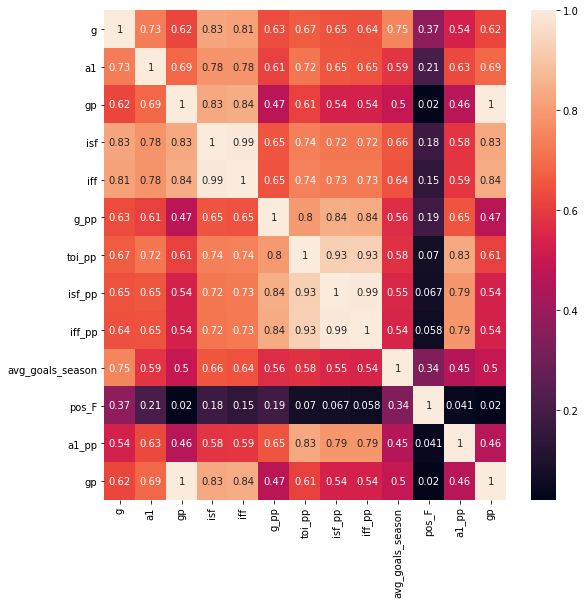

In [240]:
corr_matrix = x_train.loc[:, list(x_train.columns[KBest.get_support()]) + ['pos_F', 'a1_pp', 'gp']].corr()
# Draw the heatmap 
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(corr_matrix, annot=True, fmt='.2g')
plt.show()

In [241]:
#Our Final selected features as a blend of SelectKBest and Correlation Matrices
selected_features = ['g', 'g_pp', 'isf', 'toi_pp', 'isf_pp', 'avg_goals_season', 'g_avg_past_2_seasons',
                     'pos_F', 'gp', 'a1']

# Standardization

The last feature preprocessing of the data I will do is to Standardize the features being passed to each model. This is [required for Lasso and Ridge regressions](https://www.kaggle.com/questions-and-answers/59305) but I've decided to do it for OLS and ElasticNet as well as to keep everything equal. Standardization is the process of making sure each feature has a mean of 0 and a standard deviation of one by processing each value with this function: `x-mean(x)/standard_deviation(x)` (Liu). We'll include this step by creating a Scikit Pipeline that will transform our data and fit it all in one step

In [242]:
#Standardizing the datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


#If you are repeating code a lot it's best to wrap it in a function as you'll see below it makes training
#the models a lot easier and comparing their result on the test data sets

def cv_model(x, y, model, n_estimators: int, n_splits: int, features: list=[]):
    
    feature_array = x[features]
    estimator = Pipeline(steps=[('preprocessor', StandardScaler()),
                                ('classifier', 
                                 BaggingRegressor(model, n_estimators=n_estimators, bootstrap=True))])
    estimator.fit(feature_array, y.values[:, 0])

    y_hat_values = estimator.predict(feature_array)
    #Testing the coefficient of determination in the training set. R^2 is the proportion
    #of the variance in the dependent variable that is predictable from the independent variables
    r_squared = estimator.score(feature_array, y)
    #Mean Squared Error is used to compare between different models where the smaller the number the better
    #An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
    #estimator or MVUE(minimum Variance Unbiased Estimator)
    mse = mean_squared_error(y, y_hat_values)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, y_hat_values)

    print(f"Building model with features: {features}")
    print(("Baseline linear model training set metrics:\n"
           f"R^2 for test set: {round(r_squared, 4)}\n"
           f"Mean Squared Error for training set: {round(mse, 4)}\n"
           f"Root Mean Squared Error for training set: {round(rmse, 4)}\n"
           f"Mean Absolute Error for training set: {round(mae, 4)}\n"
           ))
 
    return estimator

#make producing Out of Sample metrics easier
def oos_stats(x_test, y_test, features, model, model_name):
    standardized_df = x_test[features]
    mse = mean_squared_error(y_test, model.predict(standardized_df))
    rmse = math.sqrt(mean_squared_error(y_test, model.predict(standardized_df)))
    mae = mean_absolute_error(y_test, model.predict(standardized_df))
    r_sq = model.score(standardized_df, y_test)
    print(f"Building {model_name} with features: {features}")
    print((f"{model_name} model Out of Sample metrics:\n"
           f"R^2: {round(r_sq, 4)}\n"
           f"Mean Squared Error: {round(mse, 4)}\n"
           f"Root Mean Squared Error: {round(rmse, 4)}\n"
           f"Average Mean Absolute Error for test set: {round(mae, 4)}"
           ))

# BaggingRegressor

For all the regression models, I will be using Scikit Learns Bagging Regressor. The Bagging Regressor is a meta estimator that combines multiple regressions trained from data randomly drawn with replacement from our training data set known as Bootstrappping. Bagging itself means Bootstrap plus aggregating. So to break it down the bagging regressor gets passed a parameter `n_estimators` which will tell it how many base estimators to make. In order to create the dataset for each base estimator to train on, the algorithim will pull from the training data randomly with replacement. This means that you could draw the same row multiple times. For example, say i have a bag with a red jelly bean, a black jelly bean, and a white jelly bean. I need to draw a sample of three jelly beans. I draw the first one its red, I then replace the red jelly bean back in the bag meaning I could draw it again. I repeat this until i have drawn three jelly beans and this is my sample.

By creating these multiple models based on random sampling it will allow us to create a distribution of what the number of goals the model expects a player to score in the next season. This allows us to judge the uncertainty of the model in its predictions by determining the variance and standard deviation of the results of each model for the player. (Brownlee)

The first regression we will be working with in this article is the Ordinary Least Squares Linear regresssion. It is commonly abbreviated to OLS and that is how I will refer to it from now on.

In [243]:
estimator = cv_model(x_train, y_train, LinearRegression(), 500, 10, features=selected_features)

Building model with features: ['g', 'g_pp', 'isf', 'toi_pp', 'isf_pp', 'avg_goals_season', 'g_avg_past_2_seasons', 'pos_F', 'gp', 'a1']
Baseline linear model training set metrics:
R^2 for test set: 0.5527
Mean Squared Error for training set: 27.5709
Root Mean Squared Error for training set: 5.2508
Mean Absolute Error for training set: 3.5746



In [244]:
oos_stats(x_test, y_test, selected_features, estimator, 'Linear Regression')

Building Linear Regression with features: ['g', 'g_pp', 'isf', 'toi_pp', 'isf_pp', 'avg_goals_season', 'g_avg_past_2_seasons', 'pos_F', 'gp', 'a1']
Linear Regression model Out of Sample metrics:
R^2: 0.5364
Mean Squared Error: 27.6984
Root Mean Squared Error: 5.2629
Average Mean Absolute Error for test set: 3.5089


# OLS Assumptions

There are four principal assumptions which justify the use of linear regression models for purposes of inference or prediction. This list of assumptions is taken from the Duke notes on linear regression:

1. linearity and additivity of the relationship between dependent and independent variables:
    * The expected value of dependent variable is a straight-line function of each independent variable, holding the others fixed.
    * The slope of that line does not depend on the values of the other variables.
    * The effects of different independent variables on the expected value of the dependent variable are additive.


2. statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data)
3. homoscedasticity (constant variance) of the errors:
    * versus time (in the case of time series data)
    * versus the predictions
    * versus any independent variable
        
        
4. normality of the error distribution. (Duke)


# Violations of linearity or additivity

>Violations of linearity or additivity are extremely serious: if you fit a linear model to data which are nonlinearly or nonadditively related, your predictions are likely to be seriously in error, especially when you extrapolate beyond the range of the sample data. (Duke) 

We'll look at this by plotting the observed versus predicted values to see if they have a linear relationship. We'll also look at the plot of the residuals vs. predicted values which should be disributed around a horizontal line with constant variance

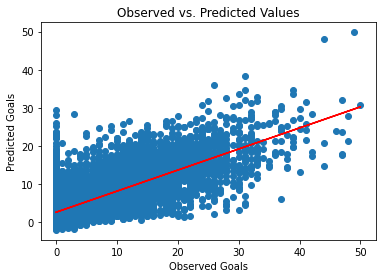

In [245]:
#total scatter correlation
#this is the test of linearity
m, b = np.polyfit(y_train.values[:,0], estimator.predict(x_train[selected_features]), 1)
plt.plot(y_train, m * y_train + b, color="red")
plt.scatter(y_train, estimator.predict(x_train[selected_features]))
plt.xlabel("Observed Goals")
plt.ylabel("Predicted Goals")
plt.title("Observed vs. Predicted Values")
plt.show()

As you can see the observed versus have a decent positive linear relation so there is no violation of linearity but these graphs are deceiving so it is best to look at the residuals versus predicted values.

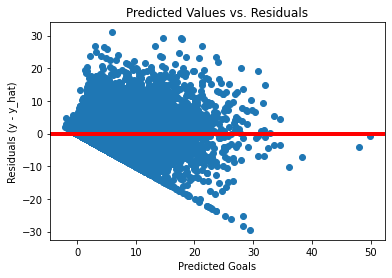

In [246]:
plt.scatter(estimator.predict(x_train[selected_features]),
            y_train.values[:, 0]-estimator.predict(x_train[selected_features]))

plt.xlabel("Predicted Goals")
plt.ylabel("Residuals (y - y_hat)")
plt.title("Predicted Values vs. Residuals")
plt.axhline(y=0, color="red", lw=4)
plt.show()

There are some issues with the smaller values in dataset and not having negative residuals. This is most likely because of the fact you can't score negative goals and your total the next season will never go below zero. Another reason is that we are using linear regression on counting data. Linear Regression is supposed to be used on continuous data sets but sometimes you can fudge it a bit if your results are good enough.

# Violations of independence
Here we check to see if any of our features are correlated with the residuals. Like with our predicted values the variance should be constant between each feature and the residual for that row. Again we will probably see issues at the lower end because of the non negative values of our data.

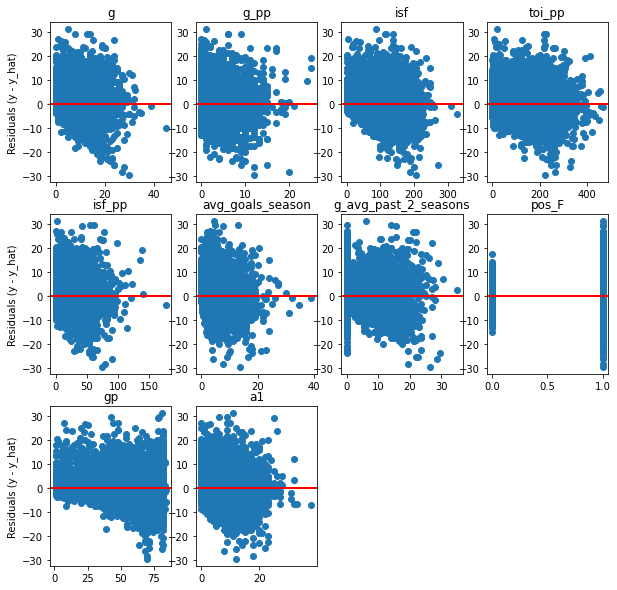

In [247]:
import math
x_row = 0
fig, axs = plt.subplots(3, 4, figsize=(10,10))
for i, f in enumerate(selected_features):
    test = [x[i] for x in estimator['preprocessor'].transform(x_train[selected_features])]
    residuals = y_train.values[:, 0]-estimator.predict(x_train[selected_features])
    axs[math.floor(x_row), i%4].scatter(x_train[f], residuals)

    #axs[math.floor(x_row), i%4].set_xlabel(f"{f}")
    if math.floor(x_row) in [0,1,2] and i%4 == 0:
        axs[math.floor(x_row), i%4].set_ylabel("Residuals (y - y_hat)")
    axs[math.floor(x_row), i%4].set_title(f"{f}")
    axs[math.floor(x_row), i%4].axhline(y=0, color="red", lw=2)
    x_row += .25
    
#removing empty plots
fig.delaxes(axs[2][2])
fig.delaxes(axs[2][3])

As with our predicted vs residual graphs we see the same issues for values closer to zero and the absence of negative residuals. However, I think we can confirm the lack of correlation between the features and our residuals showing our features are staistically independent from our errors.

# Violations of homoscedasticity

To check this we again look out our predicted vs. residuals plot we made above. And again it doesn't look like the variance of the residuals is a constant value across the predicted values. When your data isn't homoscedastic it's considered heteroscedastic meaning that the variability of the errors is different acros the vector of our predicted values.

> \[Hetereoscedasticity\] make\[s\] it difficult to gauge the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide or too narrow. In particular, if the variance of the errors is increasing over time, confidence intervals for out-of-sample predictions will tend to be unrealistically narrow. Heteroscedasticity may also have the effect of giving too much weight to a small subset of the data (namely the subset where the error variance was largest) when estimating coefficients. (Duke)

While this might be a minor violation of this assumption, its more likely because we are using OLS regression on a counting data set instead of a continuous one. In the next sections of this series we will look at regressions that deal with these types of datasets, but for now the results of our regression is still pretty decent so we'll stick with it

# Violations of normality

We will look to make sure the errors, or residuals, from our regression are normally distributed. The best way to do this graphically is with a QQ plot with compares the residuals at a quantile level to the distribution we are assuming they came from in this case the normal distribution. Below you can see the average is close to 0 but not quite again which is a condition of normality in the distribution of our residuals.

In [248]:
resid_avg = np.average(residuals)
print(f"Average of the residuals: {resid_avg}")

Average of the residuals: 0.0006283256370234607


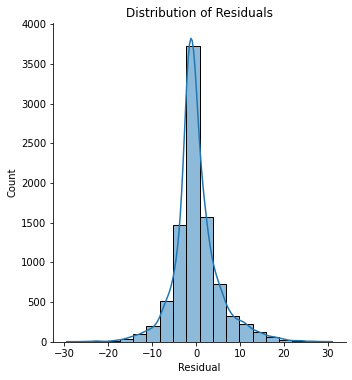

In [249]:
import seaborn as sns
sns.displot(data=residuals, kde=True, bins=20)
plt.xlabel("Residual")
plt.title("Distribution of Residuals")
plt.show()

The plot looks sort of like a normal distribution. We can investigate this further by looking at a QQ plot of the reisudals as described below:

> A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that’s roughly straight. Here’s an example of a Normal Q-Q plot when both sets of quantiles truly come from Normal distributions. (UVA)

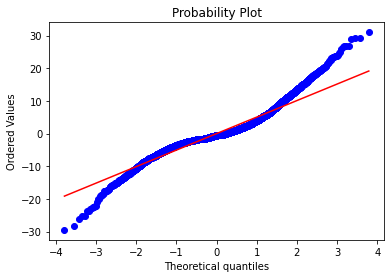

In [250]:
#QQ plot or normal quantile plot
import scipy
scipy.stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

The S Shaped curve of our QQ plot is showing that our residuals are influenced by outliers in our residuals. Particularly this S shaped curve demonstrates heavy tail outliers in our residuals which can be seen in the histogram plot above. This means that the assumptions of Normality aren't quite met, but they are pretty close and probably aren't large enough to severely effect the predictions of the model (Love).

# Beyond OLS Regression

## Ridge Regression
In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients. So ridge regression puts a constraint on the coefficients. The penalty term (alpha) constrains the coefficients such that if the coefficients take large values the optimization function is penalized. So, ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity (Bhattacharyya).

The shrinking of the coefficients is also known by the term Regularization. 
>"If you’ve heard of them before, you must know that they work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. These are called ‘regularization’ techniques," (AARSHAY JAIN). 

In Ridge Regression it uses the L2 Norm regularization which is a penalty equivalent to square of the magnitude of coefficients. L2 Norm is also known as the [Euclidean Norm](https://en.m.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm) which is basically the distance from the origin to the point of the vector.

In sklearn alpha is used to determine the penalty applied to the features as it uses the `||y - Xw||^2_2 + alpha * ||w||^2_2` as the objective, or loss, function. So basically what this is saying is that the lower the alpha value the closer your Ridge Regression will be to a regular OLS regression. The higher the value of alpha the more the regression will penalize those features that have high colinearity and reduce their coeffcients closer to 0 without actually being 0. This helps with model complexity and overfitting of the model from colinearity. 

It is more common though to use a lambda parameter for the penalty in other programming languages such as R instead of the alpahs we will be passing to our Scitkit Learn models. I generally work with lambda values so I can communicate easier with other data scientists without confusion so I convert my lambda values into the equivalent alpha values so that if I make a regression using .5 as a lambda value then an R user or someone else can take my data and create the same model by using the .5 values themselves.

In [251]:
#Normally most people refer to the penalization variable as lambda when talking about Ridge Regressions in math
#or R. However we need to convert those lambdas to our alpha for the sklearn. There is a link in the sources 
#that discus the math behind this in detail
def lambda_to_alpha(lambda_value, samples):
    return (lambda_value * samples) / 2.0

# Cross Validation

The next technique I'll be introducing is kFold Cross Validation and Grid Search. These are two common concepts in modeling where basically you just try every combination possible until you find one that does well. For larger models that take a lot of time to train this becomes a problem but for our models time to train won't be an issue.

kFold Cross Validation (CV) is a technique where you create k training and testing sets at random from the data and train models on each training partition and then run them on the associated testing set. For each of the Elastic Net, Ridge, and Lasso models I'll be using cross validation with 10 folds. This means that it will repeat the test train split on the data 10 times and then average the score for the model to see how it performs. For these examples we'll be using the R^2 metric but you could use any metric you wanted that Scikit Learn allows such as MAE or MSE. If you aren't familiar with kFold Cross Validation you can read about it [here](https://machinelearningmastery.com/k-fold-cross-validation/). I highly suggest you are comfortable with this before moving on in the article as it will be a key component in how the models are built.

These models will also do a Grid Search on the alpha parameters I'm passing to them. So the `BaggingReggressor` will bootstrap a smaple. Then the `RidgeCV` will run a 10 fold CV on that sample with each value of alpha I pass it. It will then save the model with the alpha value that has the best average R^2 score during cross validation. The `BaggingRegressor` will then repeat this 499 more times create a new Ridge regression. This will work the same for Lasso and Elastic Net just replace all instances of Ridge with either Lasso or Elastic Net. 

In [252]:
from sklearn.linear_model import RidgeCV
lambdas_ridge = [0.01, 0.025, 0.05, .075, 0.1]
alpha_ridge = [lambda_to_alpha(l, x_train.shape[0]) for l in lambdas_ridge]
ridge_estimator = cv_model(x_train, y_train, RidgeCV(alphas=alpha_ridge, cv=10), 500, 10, 
                           features=feature_columns)

Building model with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Baseline linear model training set metrics:
R^2 for test set: 0.5603
Mean Squared Error for training set: 27.1019
Root Mean Squared Error for training set: 5.2059
Mean Absolute Error for training set: 3.5515



As seen below, the Ridge Regression performs worse on the test data than the training data. This is to be expected and almost always will be the case with any model and will be the same with Lasso and Elastic Net. In fact if your model improves on the test set I would be highly wary and start investigating to make sure there was no data leakage between your training and test sets.

In [253]:
oos_stats(x_test, y_test, feature_columns, ridge_estimator, 'Ridge Regression')

Building Ridge Regression with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Ridge Regression model Out of Sample metrics:
R^2: 0.5377
Mean Squared Error: 27.6164
Root Mean Squared Error: 5.2551
Average Mean Absolute Error for test set: 3.5215


## Lasso Regression

We are going to repeat the steps above but this time use a Lasso regression instead of a Ridge Regression. With Lasso, the algorithm will reduce to 0 any features that are highly colinear. The Lasso Regression applies a penalty weight to the L1 norm(or taxicab/Manhattan distance) of the features which is the sum of the absolute value of the components of the feature vector and uses this formula as its optimization function `(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1`. Lasso uses the sum of the coefficients instead of the coefficients squared which is why you can get zero values for coefficients in Lasso (Bahattacharyya). 


In [254]:
#the LassoCV takes a much smaller values of lambda to get a good result. 
#Tis is mainly due to the different cost functions for the regression. 
#Lasso uses L1 normalization while Ridge uses L2. 
from sklearn.linear_model import LassoCV
lasso_lambdas = [.01, .001, .002, .003, .0001]
lasso_alphas = [lambda_to_alpha(l, x_train.shape[0]) for l in lasso_lambdas]
lasso_estimator = cv_model(x_train, y_train, LassoCV(alphas=lasso_alphas, max_iter=1000), 
                           500, 10, features=feature_columns)

Building model with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Baseline linear model training set metrics:
R^2 for test set: 0.5402
Mean Squared Error for training set: 28.3422
Root Mean Squared Error for training set: 5.3237
Mean Absolute Error for training set: 3.6547



In [255]:
oos_stats(x_test, y_test, feature_columns, lasso_estimator, 'Lasso Regression')

Building Lasso Regression with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Lasso Regression model Out of Sample metrics:
R^2: 0.5282
Mean Squared Error: 28.1826
Root Mean Squared Error: 5.3087
Average Mean Absolute Error for test set: 3.5789


# ElasticNet Regression

ElasticNet Regression is a combination of Ridge and Lasso Regressions. It combines the cost functions of both Lasso and Ridge Regression(L1 and L2 Regularization respectively) to try to get the best of both worlds (Oleszak). In most literature this is called an alpha parameter with alpha=0 being a pure ridge regression and alpha=1 being Lasso. Of course Scikit Learn uses alpha as its lambda (confusing I know but I find it better to refer to them as everyone else does instead of what Scikit does to avoid confusion).

So the alpha parameter is called the `l1_ratio` in the sklearn ElasticNet model. Its a value from 0 to 1 with the same setup as the alpha. It also takes an `alphas` parameter like the Ridge/Lasso models which is the penalization hyperparameter as above. With `ElasticNet` there are now two hyperparameters to tune: `l1_ratio` (alpha) and `alphas` (lambda). Im using a combination of lambdas from the previous two models and a standard alpha selection found in the Scikit Learn docs on ElasticNetCV that states that you should have more values closer to 1 than 0.

In [256]:
from sklearn.linear_model import ElasticNetCV
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
elastic_alphas = lasso_alphas + alpha_ridge
elastic_estimator = cv_model(x_train, y_train, ElasticNetCV(l1_ratio=l1_ratios, alphas=elastic_alphas), 
                             500, 10, features=feature_columns)

Building model with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Baseline linear model training set metrics:
R^2 for test set: 0.5449
Mean Squared Error for training set: 28.0503
Root Mean Squared Error for training set: 5.2963
Mean Absolute Error for training set: 3.6127



In [257]:
oos_stats(x_test, y_test, feature_columns, elastic_estimator, 'ElasticNet Regression')

Building ElasticNet Regression with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
ElasticNet Regression model Out of Sample metrics:
R^2: 0.5326
Mean Squared Error: 27.9245
Root Mean Squared Error: 5.2844
Average Mean Absolute Error for test set: 3.5387


# Comparing the Four Models

In [258]:

print(f"Comparing R^2 of Models on Test Set:")
print((f'{"Elastic Net:":<15}{round(elastic_estimator.score(x_test, y_test), 4):>10}\n'
       f'{"Lasso:":<15}{round(lasso_estimator.score(x_test, y_test), 4):>10}\n'
       f'{"Ridge:":<15}{round(ridge_estimator.score(x_test, y_test), 4):>10}\n'
       f'{"OLS:":<15}{round(estimator.score(x_test[selected_features], y_test), 4):>10}\n'
       ))
print("Comparing MAE of Models on Test Set:")
print((f'{"Elastic Net:":<15}{round(mean_absolute_error(elastic_estimator.predict(x_test), y_test), 4): >10}\n'
       f'{"Lasso:":<15}{round(mean_absolute_error(lasso_estimator.predict(x_test), y_test), 4):>10}\n'
       f'{"Ridge:":<15}{round(mean_absolute_error(ridge_estimator.predict(x_test), y_test), 4):>10}\n'
       f'{"OLS:":<15}{"{:.4f}".format(round(mean_absolute_error(estimator.predict(x_test[selected_features]), y_test), 4)):>10}\n'
       ))

Comparing R^2 of Models on Test Set:
Elastic Net:       0.5326
Lasso:             0.5282
Ridge:             0.5377
OLS:               0.5364

Comparing MAE of Models on Test Set:
Elastic Net:       3.5387
Lasso:             3.5789
Ridge:             3.5215
OLS:               3.5089



The main take away from this is that by using Ridge, Lasso, or ElasticNet we can skip the feature selection steps of our OLS model and just let the model select our features for us. For something with as small of features as this either choice isn't going to be that much time, but when you have hundreds of features to choose from then using one of these three regularized regressions will greatly speed up things. You an also use something like Lasso that zeros out features to help decide what features you may want to pass to another non linear regression model to help improve its performances as well.

# Improving the Model

So it looks like Ridge Regression is our best performing model overall although Elastic Net scores close as well. Overall are these scores are all right. They aren't great but they aren't awful, generally I'd like a R squared of above .70 if possible although that varies with what your are predicting too. Sometimes an R^2 of .6 is very good given the dificulty of what you are predicting. As a good baseline model these metrics are pretty good for the minimal amount of work put into acutally building the model itself. So now that there is baseline its time work on improving the model some.

One thing that could help improve the model is to split our power play features and even strength features into two seperate models. Right now we are using power play stats along with even strength stats from the previous season to predict the total goals for a player. Sometimes it is better to have multiple simpler models instead of one more complex model. This is sort of the idea behind Boosting in machine learning as well which is beyond the scope of this article but keep it in mind as I'll probably touch on it in future entries. On to the next step!


# Two Seperate Models

In [259]:
ev_goals = next_df[['g', 'a1', 'a2', 'toi', 'gp', 'isf', 
                    'iff', 'g_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp']]
ev_features = ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 
               'pos_D', 'pos_D/F', 'pos_F', 'toi_gp']
ev_target = ['g_next']
pp_goals = next_df[['g_pp', 'a1_pp', 'a2_pp', 'toi_pp',
                    'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F', 'g_pp_next']]
pp_features = ['g_pp', 'a1_pp', 'a2_pp', 'toi_pp',
                     'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F']
pp_target = ['g_pp_next']

x_ev_train, x_ev_test, y_ev_train, y_ev_test = train_test_split(next_df[ev_features], 
                                                                next_df[ev_target], 
                                                                test_size=0.2, random_state=400)
x_pp_train, x_pp_test, y_pp_train, y_pp_test = train_test_split(next_df[pp_features], 
                                                                next_df[pp_target], 
                                                                test_size=0.2, random_state=600)

## Ridge Even Strength and Power Play Goals models

In [260]:
lambdas_ridge = [0.01, 0.025, 0.05, .075, 0.1]
alpha_ridge = [lambda_to_alpha(l, x_train.shape[0]) for l in lambdas_ridge]
ridge_ev_estimator = cv_model(x_ev_train, y_ev_train, RidgeCV(alphas=alpha_ridge, cv=10), 500, 10, 
                           features=ev_features)

Building model with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp']
Baseline linear model training set metrics:
R^2 for test set: 0.4838
Mean Squared Error for training set: 16.6624
Root Mean Squared Error for training set: 4.082
Mean Absolute Error for training set: 2.8648



In [261]:
lambdas_ridge = [0.01, 0.025, 0.05, .075, 0.1]
alpha_ridge = [lambda_to_alpha(l, x_train.shape[0]) for l in lambdas_ridge]
ridge_pp_estimator = cv_model(x_pp_train, y_pp_train, RidgeCV(alphas=alpha_ridge, cv=10), 500, 10, 
                           features=pp_features)

Building model with features: ['g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F']
Baseline linear model training set metrics:
R^2 for test set: 0.465
Mean Squared Error for training set: 4.0544
Root Mean Squared Error for training set: 2.0136
Mean Absolute Error for training set: 1.2256



In [262]:
oos_stats(x_ev_test, y_ev_test, ev_features, ridge_ev_estimator, 'EV Ridge Regression')

Building EV Ridge Regression with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp']
EV Ridge Regression model Out of Sample metrics:
R^2: 0.5112
Mean Squared Error: 15.384
Root Mean Squared Error: 3.9222
Average Mean Absolute Error for test set: 2.7633


In [263]:
oos_stats(x_pp_test, y_pp_test, pp_features, ridge_pp_estimator, 'PP Ridge Regression')

Building PP Ridge Regression with features: ['g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F']
PP Ridge Regression model Out of Sample metrics:
R^2: 0.4441
Mean Squared Error: 4.0158
Root Mean Squared Error: 2.0039
Average Mean Absolute Error for test set: 1.2586


In [264]:
ev_goals = ridge_ev_estimator.predict(x_test[ev_features])
pp_goals = ridge_pp_estimator.predict(x_test[pp_features])
predicted_goals = ev_goals + pp_goals
mse = mean_squared_error(y_test, predicted_goals)
rmse = math.sqrt(mean_squared_error(y_test, predicted_goals))
mae = mean_absolute_error(y_test, predicted_goals)
from sklearn.metrics import r2_score
r_sq = r2_score(y_test, predicted_goals)
print(f"Building Combined PP/EV goal regressions")
print((f"Combined PP/EV model Out of Sample metrics:\n"
       f"R^2: {round(r_sq, 4)}\n"
       f"Mean Squared Error: {round(mse, 4)}\n"
       f"Root Mean Squared Error: {round(rmse, 4)}\n"
       f"Mean Absolute Error for test set: {round(mae, 4)}"
       ))

Building Combined PP/EV goal regressions
Combined PP/EV model Out of Sample metrics:
R^2: 0.5305
Mean Squared Error: 28.0508
Root Mean Squared Error: 5.2963
Mean Absolute Error for test set: 3.571


## Elastic Net Even Strength and Power Play Goals models

In [265]:
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
elastic_alphas = lasso_alphas + alpha_ridge
elastic_ev_estimator = cv_model(x_ev_train, y_ev_train, ElasticNetCV(l1_ratio=l1_ratios, alphas=elastic_alphas), 
                             500, 10, features=ev_features)
elastic_pp_estimator = cv_model(x_pp_train, y_pp_train, ElasticNetCV(l1_ratio=l1_ratios, alphas=elastic_alphas), 
                             500, 10, features=pp_features)

Building model with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp']
Baseline linear model training set metrics:
R^2 for test set: 0.4624
Mean Squared Error for training set: 17.3513
Root Mean Squared Error for training set: 4.1655
Mean Absolute Error for training set: 2.9574

Building model with features: ['g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F']
Baseline linear model training set metrics:
R^2 for test set: 0.4556
Mean Squared Error for training set: 4.1251
Root Mean Squared Error for training set: 2.031
Mean Absolute Error for training set: 1.2131



In [266]:
ev_goals = elastic_ev_estimator.predict(x_test[ev_features])
pp_goals = elastic_pp_estimator.predict(x_test[pp_features])
predicted_goals = ev_goals + pp_goals
mse = mean_squared_error(y_test, predicted_goals)
rmse = math.sqrt(mean_squared_error(y_test, predicted_goals))
mae = mean_absolute_error(y_test, predicted_goals)
from sklearn.metrics import r2_score
r_sq = r2_score(y_test, predicted_goals)
print((f"Combined Elastic PP/EV model Out of Sample metrics:\n"
       f"R^2: {round(r_sq, 4)}\n"
       f"Mean Squared Error: {round(mse, 4)}\n"
       f"Root Mean Squared Error: {round(rmse, 4)}\n"
       f"Mean Absolute Error for test set: {round(mae, 4)}"
       ))

Combined Elastic PP/EV model Out of Sample metrics:
R^2: 0.5087
Mean Squared Error: 29.3515
Root Mean Squared Error: 5.4177
Mean Absolute Error for test set: 3.7008


## Lasso Even Strength and Power Play Goals models

In [267]:
lasso_lambdas = [.01, .001, .002, .003, .0001]
lasso_alphas = [lambda_to_alpha(l, x_train.shape[0]) for l in lasso_lambdas]
lasso_ev_estimator = cv_model(x_ev_train, y_ev_train, LassoCV(alphas=lasso_alphas, max_iter=1000), 
                           500, 10, features=ev_features)
lasso_pp_estimator = cv_model(x_pp_train, y_pp_train, LassoCV(alphas=lasso_alphas, max_iter=1000), 
                           500, 10, features=pp_features)

Building model with features: ['g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp']
Baseline linear model training set metrics:
R^2 for test set: 0.4593
Mean Squared Error for training set: 17.4516
Root Mean Squared Error for training set: 4.1775
Mean Absolute Error for training set: 2.9714

Building model with features: ['g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'pos_D', 'pos_D/F', 'pos_F']
Baseline linear model training set metrics:
R^2 for test set: 0.4204
Mean Squared Error for training set: 4.3921
Root Mean Squared Error for training set: 2.0957
Mean Absolute Error for training set: 1.3139



In [268]:
ev_goals = lasso_ev_estimator.predict(x_test[ev_features])
pp_goals = lasso_pp_estimator.predict(x_test[pp_features])
predicted_goals = ev_goals + pp_goals
mse = mean_squared_error(y_test, predicted_goals)
rmse = math.sqrt(mean_squared_error(y_test, predicted_goals))
mae = mean_absolute_error(y_test, predicted_goals)
from sklearn.metrics import r2_score
r_sq = r2_score(y_test, predicted_goals)
print((f"Combined Lasso PP/EV model Out of Sample metrics:\n"
       f"R^2: {round(r_sq, 4)}\n"
       f"Mean Squared Error: {round(mse, 4)}\n"
       f"Root Mean Squared Error: {round(rmse, 4)}\n"
       f"Mean Absolute Error for test set: {round(mae, 4)}"
       ))

Combined Lasso PP/EV model Out of Sample metrics:
R^2: 0.4982
Mean Squared Error: 29.9753
Root Mean Squared Error: 5.475
Mean Absolute Error for test set: 3.7992


Comparing R^2 of Models on Test Set:
Elastic Net:       0.6078
Lasso:             0.5976
Ridge:             0.6137
OLS:               0.6032

Comparing MAE of Models on Test Set:
Elastic Net:       3.6324
Lasso:             3.6794
Ridge:             3.6011
OLS:               3.6390

From the test metrics above splitting out regular season goals and power play goals into their own seperate models doesnt seem to improve our model performance at all. It's possible we could have reached the limits of what regression can do in this case, but either way we have a good method now of building models and testing them so we can quickly determine how our changes are able to improve the models. Now lets look and see what our regular Ridge Regression predicts for the top ten goals scorers for next season

In [309]:
next_df['predicted_goals'] = ridge_estimator.predict(next_df[feature_columns])
last_season_df = next_df[next_df.season == 20192020]
last_season_df = last_season_df.sort_values('predicted_goals', ascending=False).reset_index(drop=True)
top_20 = last_season_df[['player', 'predicted_goals']].head(20)
top_20['rank'] = top_20.index + 1
top_20['predicted_goals'] = round(top_20['predicted_goals'], 0)
top_20

,player,predicted_goals,rank
0,Auston Matthews,29.0,1
1,David Pastrnak,28.0,2
2,Alex Ovechkin,26.0,3
3,Leon Draisaitl,25.0,4
4,Nathan MacKinnon,25.0,5
5,Elias Pettersson,23.0,6
6,Artemi Panarin,23.0,7
7,Brady Tkachuk,22.0,8
8,Connor McDavid,22.0,9
9,Dominik Kubalik,22.0,10


As we can see the names look about right however the totals are heavily depressed this is most likely due to the regression weighting the fact that most players don't score a lot of goals so to improve scoring it artifically depresses values to optimize it errors. As mentioned above the `BaggingRegressor` allows us to create a distribution of goal values as seen below.

In [307]:
results = []
matthews = last_season_df.loc[11092, feature_columns].values.reshape(1, -1)
for model in ridge_estimator['classifier'].estimators_:
    results.append(model.predict(ridge_estimator['preprocessor'].transform(matthews)))

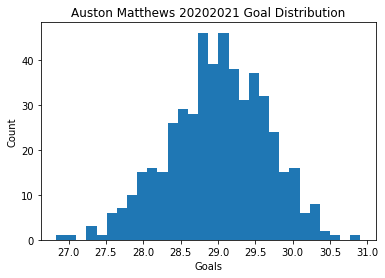

In [308]:
cleaned_results = [x[0] for x in results]
plt.hist(cleaned_results, bins=30)
plt.title('Auston Matthews 20202021 Goal Distribution')
plt.xlabel('Goals')
plt.ylabel('Count')
plt.show()

# Sources
Ridge and Lasso Regression: L1 and L2 Regularization by Saptashwa Bhattacharyya
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

Ridge Regression Cost Function by Aleksy Bilogur 
https://www.kaggle.com/residentmario/ridge-regression-cost-function

Alpha parameter in ridge regression is high Cross Validated
https://stats.stackexchange.com/questions/166950/alpha-parameter-in-ridge-regression-is-high

A Complete Tutorial on Ridge and Lasso Regression in Python by AARSHAY JAIN
https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

What are the differences between ridge regresssion using R's Glmnet and Python's sklearn Cross Validated
https://stats.stackexchange.com/questions/160096/what-are-the-differences-between-ridge-regression-using-rs-glmnet-and-pythons

Scikit Learn Ridge Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

A Gentle Introduction to the Bootstrap Method by Jason Brownlee
https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/

Regularization: Ridge, Lasso and Elastic Net by Michał Oleszak
https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

Intuitions on L1 and L2 Regularisation by Raimi Karim
https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261

Hastie, T., Tibshirani, R.,, Friedman, J. (2001). The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc.. 

Norm (Mathematics) 
https://en.wikipedia.org/wiki/Norm_(mathematics)#Absolute-value_norm

Repeated k-Fold Cross-Validation for Model Evaluation in Python by Jason Brownlee
https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

What does calling fit() multiple times on the same model do Stack Overflow
https://stackoverflow.com/questions/49841324/what-does-calling-fit-multiple-times-on-the-same-model-do

Linear Regression Models, Duke University
http://people.duke.edu/~rnau/testing.htm

Understanding Q-Q Plots, University of Virginia Library
https://data.library.virginia.edu/understanding-q-q-plots/

Data Science for Biological, Medical and Health Research: Notes for 431 by Thomas E. Love PhD
https://thomaselove.github.io/2018-431-book/assessing-normality.html

Data Transformation: Standardization vs Normalization by Claire Liu
https://www.kdnuggets.com/2020/04/data-transformation-standardization-normalization.html